# **Clustering**

In this NB, we will apply what was learnt about tensor operations in the `01_matmul` notebook to classical ML algorithms - specifically unsupervised learning techniques like Clustering. 

The homework at the end of the course NB's is the key to this lesson. We should be able to extend tensor operations to other unsupervised algorithms such as dbscan, k-means clustering , fast nearest neighbours _while utilizing our GPU._ Implementing in APL is the bonus.

According to Jeremy, this is akin to knowing our times tables. So "time" to get cracking!

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create Synthetic Data

In [3]:
n_clusters = 6
n_samples = 500

We will pick 6 random points aka centroids and for each we will generate 500 random points.

In [4]:
# Create random clusters by 2 for x and y coordinates
centroids = torch.rand(n_clusters, 2) * 70-35

In [5]:
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [6]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [12]:
# Sample will run on each of the 6 centroids
def sample(m): 
    # Returns normally distributed, multivariate data with means for x and y
    # The standard deviation and mean will be 5 for these clusters. 
    # torch.diag() will create a covariance matrix since we have multivariate data.
    # finally, get the number of samples which we want.
    return MultivariateNormal(m, torch.diag(tensor([5., 5.]))).sample((n_samples,))

In [11]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([3000, 2])

In [8]:
torch.cat?

Docstring:
cat(tensors, dim=0, *, out=None) -> Tensor

Concatenates the given sequence of :attr:`seq` tensors in the given dimension.
All tensors must either have the same shape (except in the concatenating
dimension) or be a 1-D empty tensor with size ``(0,)``.

:func:`torch.cat` can be seen as an inverse operation for :func:`torch.split`
and :func:`torch.chunk`.

:func:`torch.cat` can be best understood via examples.

.. seealso::

    :func:`torch.stack` concatenates the given sequence along a new dimension.

Args:
    tensors (sequence of Tensors): any python sequence of tensors of the same type.
        Non-empty tensors provided must have the same shape, except in the
        cat dimension.
    dim (int, optional): the dimension over which the tensors are concatenated

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> x = torch.randn(2, 3)
    >>> x
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497]])
    >>> torch.cat(

In [16]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: 
        _, ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        #Grab samples in order for i to i+1
        samples = data[i*n_samples: (i+1)*n_samples]
        ax.scatter(samples[:, 0], samples[:, 1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color="k", mew=5) # Large black X
        ax.plot(*centroid, markersize=5, marker="x", color="m", mew=2) # Smaller magenta X

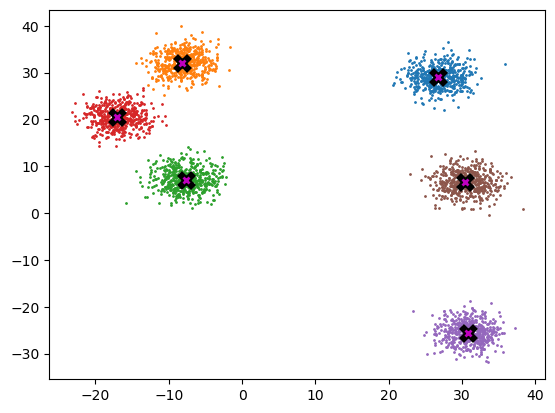

In [14]:
plot_data(centroids, data, n_samples)

## Mean Shift Algorithm

> Most people that have come across clustering algorithms have learnt about k-means. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
> - It doesn't require selecting the number of clusters in advance, but instead just requires a bandwidth to be specified, which can be easily chosen automatically
> - It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

> The algorithm is as follows:

> - For each data point x in the sample X, find the distance between that point x and every other point in X
> - Create weights for each point in X by using the Gaussian kernel of that point's distance to x
> - This weighting approach penalizes points further away from x
> - The rate at which the weights fall to zero is determined by the bandwidth, which is the standard deviation of the Gaussian
> - Update x as the weighted average of all other points in X, weighted based on the previous step

>This will iteratively push points that are close together even closer until they are next to each other.


In [17]:
# Taking the mean gives us the middle point of the variable space
# This is not the result we want. Our interest lies in taking a weighted average
midp = data.mean(0)
midp

tensor([ 9.258, 11.678])

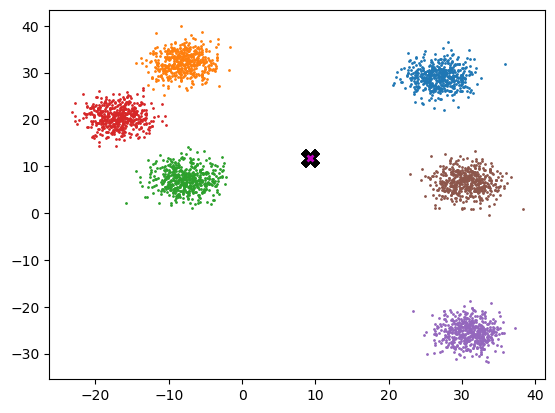

In [19]:
plot_data([midp]*6, data, n_samples)

We require a weighted average of the data points for each cluster. Each point's weights are assigned using the Gaussian Kernel.

In [20]:
def gaussian(d, bw):
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [21]:
def plot_func(f):
    x = torch.linspace(0, 10, 100)
    plt.plot(x, f(x))

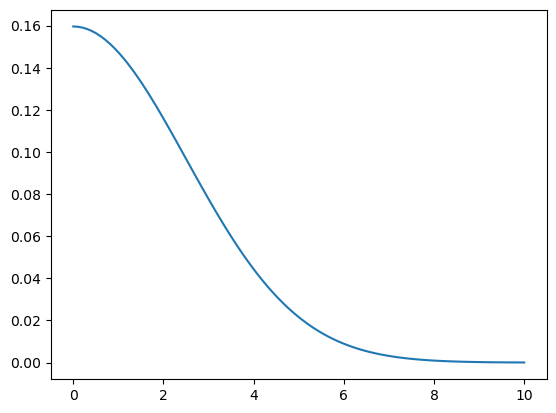

In [24]:
# We can use partial() to simplify the plotting of the function below
plot_func(partial(gaussian, bw=2.5))

Setting `bw` or `bandwidth` to 2.5 is a rule of thumb which allows us to cover 75% of the data.

A simpler alternative is to use triangular weighting for setting the bandwidth.

In [29]:
def tri(d, i):
    return (-d+i).clamp_min(0)/i

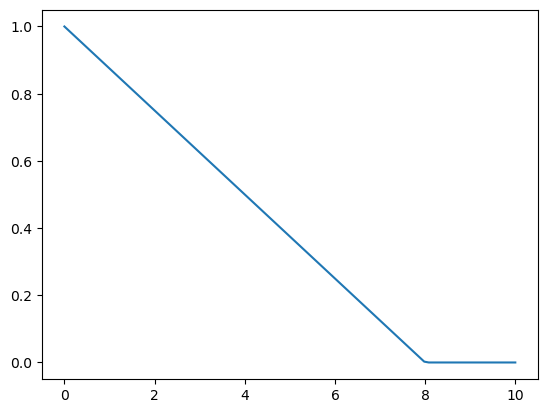

In [30]:
plot_func(partial(tri, i=8))

In [31]:
# Cloning the data by creating matrix X
X = data.clone()
x = data[0]

In [38]:
# A simple rank 1 tensor which will be used to calculate the distances from x and y
x

tensor([26.204, 26.349])

In [39]:
# Tensors and then adding a unit column to x
x.shape, X.shape, x[None].shape

(torch.Size([2]), torch.Size([3000, 2]), torch.Size([1, 2]))

Applying what was learnt in the last NB.

In [35]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [37]:
(x-X)[:8] # Same result as before since our tensors have compatible unit axes

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [40]:
# Taking the Euclidean distance 
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

**HOMEWORK**: Lets rewrite the above using Einsum to speed up operations.

In [45]:
# Einsum implementation
# <here>

In [46]:
# Calculating the weights
weight = gaussian(dist, 2.5)

In [47]:
# We will calculate the weighted average of the data X using the weights we just calculated.
weight.shape, X.shape

(torch.Size([3000]), torch.Size([3000, 2]))

In [48]:
# To make the tensors compatible for operations requires a unit axis
weight[:, None].shape

torch.Size([3000, 1])

In [49]:
weight[:, None]*X

tensor([[    4.182,     4.205],
        [    1.215,     1.429],
        [    0.749,     0.706],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

Now that we have iteratively figured out how to get the individual pieces of the mean shift algorithm to work, its time to put it into one function.

In [59]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
        # We can use the gaussian or the triangular weighting since the results will be the same.
     #   weight = gaussian(dist, 2.5) # where d is dist
        weight = tri(dist, 8)
        X[i] = (weight[:, None] * X).sum(0) / weight.sum()

In [60]:
def mean_shift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [61]:
%time X = mean_shift(data)

CPU times: user 9.98 s, sys: 84.2 ms, total: 10.1 s
Wall time: 1.01 s


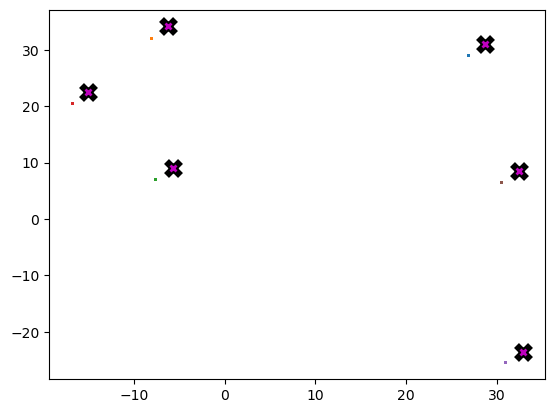

In [62]:
# We will move the centroids by 2 points to see them better
plot_data(centroids + 2, X, n_samples)